# Objective is to take the generated flight dataframe and use it to predict flight ground delays

In [1]:
# one hot encode runway
# ordinal encode airline
# TODO: Try with avg pb time, ratioH/M, ratio nominal
from traffic.core import Traffic

import pandas as pd
import numpy as np
import pickle

import os.path

from ipyleaflet import Polygon
from ipywidgets import Layout
from ipyleaflet import Map, Marker

import altair as alt

from cartes.osm import Overpass

from sklearn import svm

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix

from numpy import mean
from numpy import std
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#dep

In [2]:
from ground_analysis.build_features import gather_data

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
from ground_analysis.utils import within_Xmin
from ground_analysis.extract_flight_info import onehot_runways, assign_twy_occ

In [4]:
dep_arr_df = pd.read_pickle("../data/processed/dep_arr_df2.pkl")

In [5]:
dep_arr_df["mvt_type"].value_counts()

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ARR    19078
DEP    16464
Name: mvt_type, dtype: int64

In [27]:
%load_ext lab_black

# Regressor

In [219]:
dep_arr_df = pd.read_pickle("../data/processed/dep_arr_df5_sifiAqliScfi.pkl")

In [240]:
twy_cols = [
    "H_occ",
    "K_occ",
    "B_occ",
    "F_occ",
    "L_occ",
    "J_occ",
    "E_occ",
    "D_occ",
    "C_occ",
    "N_occ",
    "A_occ",
    "M_occ",
    "Y_occ",
    "R_occ",
    "G_occ",
    "Z_occ",
    "P_occ",
]

sifi_cols = ["aqli_DEP", "scfi_DEP", "aqli_ARR", "scfi_ARR"]

In [241]:
flight_df = dep_arr_df.query("config=='NORTH0' & end_pb==end_pb & mvt_type=='DEP'")

rwy_cols = ["rwy__10", "rwy__14", "rwy__16", "rwy__28", "rwy__32", "rwy__34"]

taxi_path_related = ["taxi_dist", "angle_sum"]  # To add if relevant

to_scale_cols = (
    [
        "hh_num",
        #  "avg_outbound_delay_lastXmin",
        "nominal",
        "busy",
        "disrupted",
        "not_nom_arrival_ratio",
        "press",
        "temp",
        "atmap_visibility",
        "atmap_wind",
        "atmap_precipitation",
        "atmap_freezing",
        "atmap_danger",
        "nb_arr",
        "nb_dep",
        "nb",
        # "H",
        #  "L",
        # "L/M",
        # "M",
        "H_count",
        "L_count",
        "L/M_count",
        "M_count",
    ]
    + twy_cols
    # + sifi_cols
)
feature_columns = to_scale_cols + rwy_cols + taxi_path_related  #

target_column = "real_dur_minutes"  # "total_holding_time_minutes"  #''    avg_outbound_delay_lastXmin  taxi_holding_time_minutes

flight_df = onehot_runways(flight_df)
data_df = flight_df[feature_columns + [target_column]].dropna()


input_df = data_df[feature_columns]
target_df = data_df[[target_column]]


from sklearn.preprocessing import StandardScaler

data_train, data_test, labels_train, labels_test = train_test_split(
    input_df,
    target_df,
    test_size=0.20,
    random_state=42,
)

"""
sc = StandardScaler()
data_train = sc.fit_transform(data_train)
data_test = sc.transform(data_test)"""
"""
model_rf = RandomForestRegressor(n_estimators=150, min_samples_split=10)"""

clf = RandomForestRegressor(n_estimators=150, min_samples_split=10)


sc = StandardScaler()
data_train = sc.fit_transform(data_train)
data_test = sc.transform(data_test)

# fit the model on the whole dataset
clf.fit(data_train, labels_train)
# make a single prediction
predicted = clf.predict(data_test)

# plot pred vs truth
data_chart = pd.DataFrame(
    {"true": labels_test.values.reshape((-1,)), "pred": predicted}
)
predVStrue_chart = alt.Chart(data_chart).mark_circle(opacity=0.5).encode(
    x="true", y="pred"
) + alt.Chart(
    pd.DataFrame({"x": np.linspace(0, 25, 10), "y": np.linspace(0, 25, 10)})
).mark_line(
    color="black"
).encode(
    x="x", y="y"
)
display(predVStrue_chart)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae = mean_absolute_error(labels_test.values.reshape((-1,)), predicted)
mse = mean_squared_error(labels_test.values.reshape((-1,)), predicted)
acc1min = within_Xmin(labels_test.values.reshape((-1,)), predicted)
acc3min = within_Xmin(labels_test.values.reshape((-1,)), predicted, m=3)
acc5min = within_Xmin(labels_test.values.reshape((-1,)), predicted, m=5)
print(
    f"mae={mae}\n mse={mse}\n acc1min={acc1min}\n acc3min={acc3min}\n acc5min={acc5min}"
)
print("And R2 = ", r2_score(labels_test.values.reshape((-1,)), predicted))

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/sklearn/ensemble/_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


alt.LayerChart(...)

mae=2.0790853003954863
 mse=10.13965094030675
 acc1min=34.68926553672316
 acc3min=76.8361581920904
 acc5min=94.4632768361582
And R2 =  0.6807468794536717


In [243]:
" ".join(feature_columns)

'hh_num nominal busy disrupted not_nom_arrival_ratio press temp atmap_visibility atmap_wind atmap_precipitation atmap_freezing atmap_danger nb_arr nb_dep nb H_count L_count L/M_count M_count H_occ K_occ B_occ F_occ L_occ J_occ E_occ D_occ C_occ N_occ A_occ M_occ Y_occ R_occ G_occ Z_occ P_occ rwy__10 rwy__14 rwy__16 rwy__28 rwy__32 rwy__34 taxi_dist angle_sum'

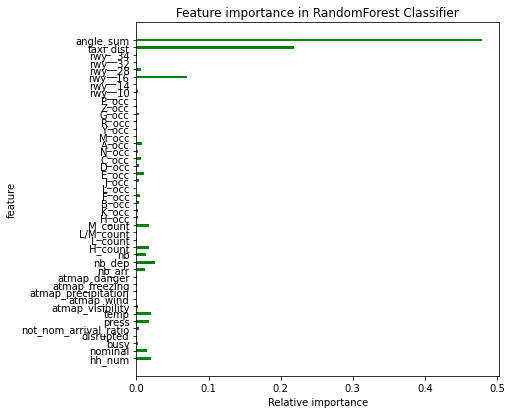

<Figure size 360x360 with 0 Axes>

In [244]:
col = feature_columns
# modelname.feature_importance_
y = clf.feature_importances_
# plot
fig, ax = plt.subplots()
width = 0.4  # the width of the bars
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="green")
ax.set_yticks(ind + width / 10)
ax.set_yticklabels(col, minor=False)
plt.title("Feature importance in RandomForest Classifier")
plt.xlabel("Relative importance")
plt.ylabel("feature")
plt.figure(figsize=(5, 5))
fig.set_size_inches(6.5, 6.5, forward=True)

In [ ]:
fdf_dep_path='../res/flight_df_v18_2019-10-01 03:58:59+00:00_2019-11-30 22:14:59+00:00_DEP.pkl'
fdf_arr_path='../res/flight_df_v21_arr_2019-10-01 04:03:04+00:00_2019-11-30 21:50:22+00:00_DEP.pkl'
metar_df_path='../data/metar_df2019-10-01 00:00:00_2019-12-01 00:00:00.pkl'
atmap_df_path='../data/lszh_metar_atmap.csv'
asma_stats_path='../data/zurich_asma_stats3.pkl'


In [ ]:
Using only dep, in NORTH0 config

features:
    hh_num avg_outbound_delay_lastXmin nominal busy disrupted press temp atmap_visibility atmap_wind atmap_precipitation atmap_freezing atmap_danger nb_arr nb_dep nb H L L/M M H_count L_count L/M_count M_count rwy__10 rwy__14 rwy__16 rwy__28 rwy__32 rwy__34


mae=2.7409766986702375
mse=12.508338887787346
acc1min=19.508057675996607
acc3min=64.29177268871925
acc5min=87.06530958439356
And R2 =  0.2818711628409082


Adding condition that flight to predict has a pb:
mae=2.967925987970022
mse=14.568926062334967
acc1min=20.51282051282051
acc3min=58.04195804195804
acc5min=83.68298368298368
And R2 =  0.23752325634538884


Adding taxi_distance and angle_turn :
mae=2.0505762933662672
mse=7.32556042247403
acc1min=34.26573426573427
acc3min=76.34032634032634
acc5min=92.77389277389277
And R2 =  0.6051400815381655


SAME FEATURES (detailed) but target = taxi_holding instead of total_holding

mae=1.9773824938758282
mse=7.1832039458098045
acc1min=34.4988344988345
acc3min=80.41958041958041
acc5min=94.17249417249417
And R2 =  0.4582989952400949

NOT DETAILED and 'hh_num nominal busy disrupted press temp atmap_visibility atmap_wind atmap_precipitation atmap_freezing atmap_danger nb_arr nb_dep nb H L L/M M H_count L_count L/M_count M_count rwy__10 rwy__14 rwy__16 rwy__28 rwy__32 rwy__34'
TRYING TO   avgdelaylastXmin
mae=1.1715029516824287
mse=3.1536762110189285
acc1min=54.54545454545454
acc3min=93.35664335664336
acc5min=98.83449883449883
And R2 =  0.4190943336137156


# Can we just predict with linear regression between delay and nb_dep ?

# Predict avg delay last Xmin (30mins ahead)

In [44]:
dep_fulltraj_df = dep_arr_df.query(" mvt_type=='DEP'")

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
turnaround_path = "../data/intermediate/zurich_turnaround.pkl"
turnaround_df = pd.read_pickle(turnaround_path)

# assign turnaround times
dep_fulltraj_df_turnaround = (
    dep_fulltraj_df.merge(
        turnaround_df.query('turnaround<"6h"')
        .assign(hh=lambda x: x.start.dt.floor("30T"))
        .drop(
            ["callsign_in", "ALDT", "AIBT", "AOBT", "start", "firstseen_min"], axis=1
        ),
        how="left",
        left_on=["callsign", "icao24", "hh"],
        right_on=["callsign_out", "icao24", "hh"],
    )
    .assign(turnaround_minutes=lambda x: x.turnaround.dt.total_seconds() / 60)
    .drop("callsign_out", axis=1)
)

dep_fulltraj_df_turnaround["turnaround_minutes"] = dep_fulltraj_df_turnaround[
    "turnaround_minutes"
].fillna(0)

In [104]:
dt_pred = pd.Timedelta("30T")

# we have to push 30mins away our target variable to predict the avg delay of next half hour
target_df = (
    dep_fulltraj_df_turnaround.sort_values("first_movement_start")[
        ["first_movement_start", "avg_outbound_delay_lastXmin"]
    ]
    .assign(first_movement_start=lambda x: x.first_movement_start - dt_pred)
    .rename(columns={"avg_outbound_delay_lastXmin": "nextAvgDelay"})
)

predict_next_avg_delay_df = pd.merge_asof(
    dep_fulltraj_df_turnaround.sort_values("first_movement_start"),
    target_df,
    on="first_movement_start",
)

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [110]:
def assign_wtc_ratios(flight_df):
    """
    Suppose that the dataframe given has WTC counts (H_count, M_count...) and Airport congestion columns (nb...)
    Be careful to keep the same time window for these precalculations
    """
    wtc_cols = ["H_count", "L_count", "L/M_count", "M_count"]
    for wtc in wtc_cols:
        flight_df[f"{wtc}_ratio"] = flight_df[wtc] / flight_df["nb"]
        flight_df.loc[flight_df[f"{wtc}_ratio"] > 1, f"{wtc}_ratio"] = 1
        flight_df.loc[flight_df[f"{wtc}_ratio"] < 0, f"{wtc}_ratio"] = 0
    return flight_df


predict_next_avg_delay_df = assign_wtc_ratios(predict_next_avg_delay_df)

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
tdf = _

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

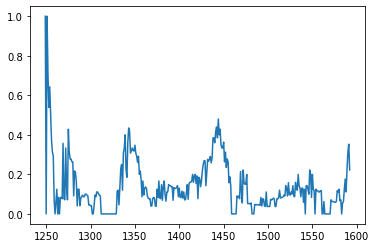

In [93]:
tdf.query(
    "hh.dt.day == 5 & hh.dt.month==10 & H_count_ratio==H_count_ratio"
).H_count_ratio.plot()

In [246]:
flight_df = predict_next_avg_delay_df

rwy_cols = ["rwy__10", "rwy__14", "rwy__16", "rwy__28", "rwy__32", "rwy__34"]

taxi_path_related = ["taxi_dist", "angle_sum"]  # To add if relevant

to_scale_cols = [
    "hh_num",
    #  "avg_outbound_delay_lastXmin",
    "nominal",
    "busy",
    "disrupted",
    "not_nom_arrival_ratio",
    "press",
    "temp",
    #   "atmap_visibility",
    #   "atmap_wind",
    #   "atmap_precipitation",
    #   "atmap_freezing",
    #   "atmap_danger",
    "nb_arr",
    "nb_dep",
    "nb",
    #   "H",
    #   "L",
    #   "L/M",
    #   "M",
    #   "H_count",
    #   "L_count",
    #   "L/M_count",
    "M_count",
    "H_count_ratio",
    "L_count_ratio",
    "L/M_count_ratio",
    "M_count_ratio",
    "turnaround_minutes",
]
feature_columns = to_scale_cols  # + rwy_cols  #

target_column = (
    "nextAvgDelay"  #'total_holding_time_minutes'      taxi_holding_time_minutes
)

flight_df = onehot_runways(flight_df)
data_df = flight_df.query("config=='NORTH0' & mvt_type=='DEP' ")[
    feature_columns + [target_column]
].dropna()


input_df = data_df[feature_columns]
target_df = data_df[[target_column]]


from sklearn.preprocessing import StandardScaler

data_train, data_test, labels_train, labels_test = train_test_split(
    input_df,
    target_df,
    test_size=0.20,
    random_state=42,
)

"""
sc = StandardScaler()
data_train = sc.fit_transform(data_train)
data_test = sc.transform(data_test)"""
"""
model_rf = RandomForestRegressor(n_estimators=150, min_samples_split=10)"""

clf = RandomForestRegressor(n_estimators=150, min_samples_split=10)


# sc = StandardScaler()
# data_train = sc.fit_transform(data_train)
# data_test = sc.transform(data_test)

# fit the model on the whole dataset
clf.fit(data_train, labels_train)
# make a single prediction
predicted = clf.predict(data_test)

# plot pred vs truth
data_chart = pd.DataFrame(
    {"true": labels_test.values.reshape((-1,)), "pred": predicted}
)
predVStrue_chart = alt.Chart(data_chart).mark_circle(opacity=0.5).encode(
    x="true", y="pred"
) + alt.Chart(
    pd.DataFrame({"x": np.linspace(0, 15, 10), "y": np.linspace(0, 15, 10)})
).mark_line(
    color="black"
).encode(
    x="x", y="y"
)
display(predVStrue_chart)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae = mean_absolute_error(labels_test.values.reshape((-1,)), predicted)
mse = mean_squared_error(labels_test.values.reshape((-1,)), predicted)
acc1min = within_Xmin(labels_test.values.reshape((-1,)), predicted)
acc3min = within_Xmin(labels_test.values.reshape((-1,)), predicted, m=3)
acc5min = within_Xmin(labels_test.values.reshape((-1,)), predicted, m=5)
print(
    f"mae={mae}\n mse={mse}\n acc1min={acc1min}\n acc3min={acc3min}\n acc5min={acc5min}"
)
print("And R2 = ", r2_score(labels_test.values.reshape((-1,)), predicted))

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/sklearn/ensemble/_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


alt.LayerChart(...)

mae=0.9534975628232467
 mse=1.7921815185492853
 acc1min=65.16949152542372
 acc3min=96.4406779661017
 acc5min=99.53389830508475
And R2 =  0.6194744292108384


In [250]:
labels_train.values.ravel()  # data_train  #

array([1.93888889, 2.98333333, 4.60897436, ..., 2.98      , 8.34777778,
       1.16111111])

In [50]:
dep_arr_df.avg_outbound_delay_lastXmin.describe()

count    16346.000000
mean         4.143773
std          2.263958
min          0.000000
25%          2.673333
50%          3.871320
75%          5.275000
max         45.316667
Name: avg_outbound_delay_lastXmin, dtype: float64

In [51]:
dep_arr_df.query(
    'mvt_type=="DEP" & end_pb==end_pb'
).avg_outbound_delay_lastXmin.describe()

count    6085.000000
mean        4.269232
std         2.363293
min         0.000000
25%         2.711111
50%         4.009722
75%         5.413889
max        25.100000
Name: avg_outbound_delay_lastXmin, dtype: float64

In [121]:
data_train.shape

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3436, 26)

In [97]:
" ".join(feature_columns)

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'hh_num nominal busy disrupted not_nom_arrival_ratio press temp nb_arr nb_dep nb M_count H_count_ratio L_count_ratio L/M_count_ratio M_count_ratio turnaround_minutes rwy__10 rwy__14 rwy__16 rwy__28 rwy__32 rwy__34'

In [ ]:
mae=1.05254925494055
 mse=2.242974923421067
 acc1min=58.139534883720934
 acc3min=96.51162790697676
 acc5min=99.4186046511628
And R2 =  0.5291628270786354

----- not full trajectories ------

BETTER Wtc counts and not_nom_arrival_ratio
'hh_num nominal busy disrupted not_nom_arrival_ratio press temp atmap_visibility atmap_wind atmap_precipitation atmap_freezing atmap_danger nb_arr nb_dep nb H_count L_count L/M_count M_count rwy__10 rwy__14 rwy__16 rwy__28 rwy__32 rwy__34'
mae=1.094219226283999
 mse=2.5313984661070292
 acc1min=59.72060535506402
 acc3min=95.69266589057042
 acc5min=99.0686845168801
And R2 =  0.4796247398927178

ADDING turnaround_minutes
'hh_num nominal busy disrupted not_nom_arrival_ratio press temp atmap_visibility atmap_wind atmap_precipitation atmap_freezing atmap_danger nb_arr nb_dep nb H_count L_count L/M_count M_count turnaround_minutes rwy__10 rwy__14 rwy__16 rwy__28 rwy__32 rwy__34'
mae=1.0568367132708232
 mse=1.9192912980800616
 acc1min=57.05521472392638
 acc3min=95.70552147239265
 acc5min=100.0
And R2 =  0.48392214899617336

----- full traj -------
'hh_num nominal busy disrupted not_nom_arrival_ratio press temp atmap_visibility atmap_wind atmap_precipitation atmap_freezing atmap_danger nb_arr nb_dep nb H_count L_count L/M_count M_count turnaround_minutes rwy__10 rwy__14 rwy__16 rwy__28 rwy__32 rwy__34'

mae=1.135557715619478
 mse=2.6320021352462013
 acc1min=56.69383003492433
 acc3min=95.22700814901047
 acc5min=98.83585564610011
And R2 =  0.4589438154167881

--- Adding wtc ratios, removing useless features --
'hh_num nominal busy disrupted not_nom_arrival_ratio press temp nb_arr nb_dep nb M_count H_count_ratio L_count_ratio L/M_count_ratio M_count_ratio turnaround_minutes'
mae=0.9574036620564338
mse=1.811342233665833
acc1min=65.42372881355932
acc3min=96.4406779661017
acc5min=99.57627118644068
And R2 =  0.6154061236396735

In [69]:
predVStrue_chart = alt.Chart(data_chart).mark_circle(opacity=0.4).encode(
    x=alt.X("true", scale=alt.Scale(domain=[0, 20], clamp=True)), y="pred"
) + alt.Chart(
    pd.DataFrame({"x": np.linspace(0, 15, 10), "y": np.linspace(0, 15, 10)})
).mark_line(
    color="black"
).encode(
    x="x", y="y"
)
display(predVStrue_chart)

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alt.LayerChart(...)

### Feature importance

In [58]:
import matplotlib.pyplot as plt

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


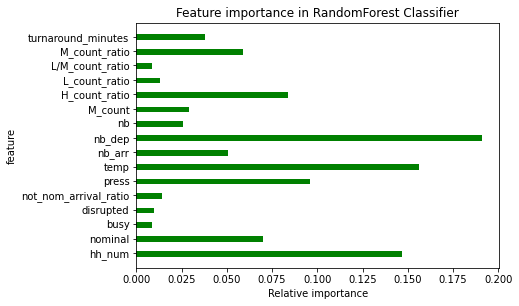

<Figure size 360x360 with 0 Axes>

In [100]:
col = feature_columns
# modelname.feature_importance_
y = clf.feature_importances_
# plot
fig, ax = plt.subplots()
width = 0.4  # the width of the bars
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="green")
ax.set_yticks(ind + width / 10)
ax.set_yticklabels(col, minor=False)
plt.title("Feature importance in RandomForest Classifier")
plt.xlabel("Relative importance")
plt.ylabel("feature")
plt.figure(figsize=(5, 5))
fig.set_size_inches(6.5, 4.5, forward=True)

# Using extrated twy congest

In [12]:
from pickle import load
with open("../data/intermediate/twy_occ_dictionnary.pkl", "rb") as f:
    d_twy = load(f)

In [13]:
dep_arr_df_twy = assign_twy_occ(dep_arr_df, d_twy)

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,flight_id,on_runway_time,taxi_holding_time,rwy_holding_time,total_holding_time,taxi_holding_time_minutes,first_movement,callsign,registration,typecode,...,D_occ,C_occ,N_occ,A_occ,M_occ,Y_occ,R_occ,G_occ,Z_occ,P_occ
0,GSW4942_15738,2019-10-01 04:00:28+00:00,0 days 00:01:23,None,0 days 00:01:23,1.383333,2019-10-01 03:59:06+00:00,GSW4942,HB-JOG,A319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,EDW200_5718,2019-10-01 04:10:37+00:00,0 days 00:01:18,None,0 days 00:04:56,1.300000,2019-10-01 04:03:36+00:00,EDW200,HB-IHZ,A320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,SWR177_15809,2019-10-01 04:05:11+00:00,0 days 00:00:00,None,0 days 00:00:00,0.000000,2019-10-01 04:05:48+00:00,SWR177,HB-JNI,B77W,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SWR139_15706,2019-10-01 04:07:25+00:00,0 days 00:00:00,None,0 days 00:00:00,0.000000,2019-10-01 04:07:33+00:00,SWR139,HB-JNG,B77W,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SWR296_13638,2019-10-01 04:09:53+00:00,0 days 00:00:00,None,0 days 00:00:00,0.000000,2019-10-01 04:10:25+00:00,SWR296,HB-JHM,A333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35537,SWR176_15653,2019-11-30 22:02:47+00:00,0 days 00:02:16,None,0 days 00:15:41,2.266667,2019-11-30 21:44:51+00:00,SWR176,HB-JNJ,B77W,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35538,SWR288_13280,2019-11-30 21:49:46+00:00,0 days 00:02:03,None,0 days 00:02:03,2.050000,2019-11-30 21:46:26+00:00,SWR288,HB-JHI,A333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35539,THY8HD_18663,2019-11-30 21:49:30+00:00,0 days 00:00:00,None,0 days 00:00:00,0.000000,2019-11-30 21:49:52+00:00,THY8HD,TC-JTN,A321,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35540,SWR92_15689,2019-11-30 22:04:18+00:00,0 days 00:03:29,None,0 days 00:09:35,3.483333,2019-11-30 21:53:56+00:00,SWR92,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
twy_cols = [
    "H_occ",
    "K_occ",
    "B_occ",
    "F_occ",
    "L_occ",
    "J_occ",
    "E_occ",
    "D_occ",
    "C_occ",
    "N_occ",
    "A_occ",
    "M_occ",
    "Y_occ",
    "R_occ",
    "G_occ",
    "Z_occ",
    "P_occ",
]

In [27]:
flight_df = dep_arr_df_twy.query("end_pb==end_pb & mvt_type=='DEP'")

rwy_cols = ["rwy__10", "rwy__14", "rwy__16", "rwy__28", "rwy__32", "rwy__34"]

taxi_path_related = ["taxi_dist", "angle_sum"]  # To add if relevant

to_scale_cols = [
    "hh_num",
    #  "avg_outbound_delay_lastXmin",
    "nominal",
    "busy",
    "disrupted",
    "not_nom_arrival_ratio",
    "press",
    "temp",
    "atmap_visibility",
    "atmap_wind",
    "atmap_precipitation",
    "atmap_freezing",
    "atmap_danger",
    "nb_arr",
    "nb_dep",
    "nb",
    # "H",
    #  "L",
    # "L/M",
    # "M",
    "H_count",
    "L_count",
    "L/M_count",
    "M_count",
] + twy_cols

feature_columns = to_scale_cols + rwy_cols  #

target_column = "avg_outbound_delay_lastXmin"  #'total_holding_time_minutes'      avg_outbound_delay_lastXmin

flight_df = onehot_runways(flight_df)
data_df = flight_df.query("config=='NORTH0' & mvt_type=='DEP' & end_pb==end_pb")[
    feature_columns + [target_column]
].dropna()


input_df = data_df[feature_columns]
target_df = data_df[[target_column]]


from sklearn.preprocessing import StandardScaler

data_train, data_test, labels_train, labels_test = train_test_split(
    input_df,
    target_df,
    test_size=0.20,
    random_state=42,
)

"""
sc = StandardScaler()
data_train = sc.fit_transform(data_train)
data_test = sc.transform(data_test)"""
"""
model_rf = RandomForestRegressor(n_estimators=150, min_samples_split=10)"""

clf = RandomForestRegressor(n_estimators=150, min_samples_split=10)


sc = StandardScaler()
data_train = sc.fit_transform(data_train)
data_test = sc.transform(data_test)

# fit the model on the whole dataset
clf.fit(data_train, labels_train)
# make a single prediction
predicted = clf.predict(data_test)

# plot pred vs truth
data_chart = pd.DataFrame(
    {"true": labels_test.values.reshape((-1,)), "pred": predicted}
)
predVStrue_chart = alt.Chart(data_chart).mark_circle(opacity=0.5).encode(
    x="true", y="pred"
) + alt.Chart(
    pd.DataFrame({"x": np.linspace(0, 15, 10), "y": np.linspace(0, 15, 10)})
).mark_line(
    color="black"
).encode(
    x="x", y="y"
)
display(predVStrue_chart)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae = mean_absolute_error(labels_test.values.reshape((-1,)), predicted)
mse = mean_squared_error(labels_test.values.reshape((-1,)), predicted)
acc1min = within_Xmin(labels_test.values.reshape((-1,)), predicted)
acc3min = within_Xmin(labels_test.values.reshape((-1,)), predicted, m=3)
acc5min = within_Xmin(labels_test.values.reshape((-1,)), predicted, m=5)
print(
    f"mae={mae}\n mse={mse}\n acc1min={acc1min}\n acc3min={acc3min}\n acc5min={acc5min}"
)
print("And R2 = ", r2_score(labels_test.values.reshape((-1,)), predicted))

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/sklearn/ensemble/_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


alt.LayerChart(...)

mae=1.1248534351674826
 mse=2.68603662894179
 acc1min=58.15850815850816
 acc3min=94.98834498834499
 acc5min=98.95104895104895
And R2 =  0.46597562539647897


In [25]:
data_train.shape

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3440, 42)

In [26]:
" ".join(feature_columns)

'hh_num nominal busy disrupted not_nom_arrival_ratio press temp atmap_visibility atmap_wind atmap_precipitation atmap_freezing atmap_danger nb_arr nb_dep nb H_count L_count L/M_count M_count H_occ K_occ B_occ F_occ L_occ J_occ E_occ D_occ C_occ N_occ A_occ M_occ Y_occ R_occ G_occ Z_occ P_occ rwy__10 rwy__14 rwy__16 rwy__28 rwy__32 rwy__34'

In [ ]:
ADDING TWY OCC
Target = total_holding_time_minutes
'hh_num nominal busy disrupted not_nom_arrival_ratio press temp atmap_visibility atmap_wind atmap_precipitation atmap_freezing atmap_danger nb_arr nb_dep nb H_count L_count L/M_count M_count H_occ K_occ B_occ F_occ L_occ J_occ E_occ D_occ C_occ N_occ A_occ M_occ Y_occ R_occ G_occ Z_occ P_occ rwy__10 rwy__14 rwy__16 rwy__28 rwy__32 rwy__34'
mae=3.015150747832123
mse=16.049552348340892
acc1min=21.511627906976745
acc3min=57.44186046511628
acc5min=84.65116279069768
And R2 =  0.2571774895290615


Same features
Target = avgLastXminu
mae=1.1248534351674826
mse=2.68603662894179
acc1min=58.15850815850816
acc3min=94.98834498834499
acc5min=98.95104895104895
And R2 =  0.46597562539647897

# Classifier

In [135]:
predict_next_avg_delay_df["nextAvgDelay_cat"] = np.where(
    predict_next_avg_delay_df["nextAvgDelay"] >= 8, 1, 0
)

In [146]:
atmap_cols = [
    "atmap_visibility",
    "atmap_wind",
    "atmap_precipitation",
    "atmap_freezing",
    "atmap_danger",
]

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [155]:
def assign_atmap_weather_score(flight_df, atmap_cols=None):
    """
    Suppose that the dataframe given has atmap score for each category
    Assign the mean value between those categories to a new column 'atmap_score'
    """
    if atmap_cols is None:
        atmap_cols = [
            "atmap_visibility",
            "atmap_wind",
            "atmap_precipitation",
            "atmap_freezing",
            "atmap_danger",
        ]
    n=len(
        atmap_cols
    )
    flight_df["atmap_score"] = flight_df[atmap_cols].agg("sum", axis=1)
    flight_df["atmap_score"] = predict_next_avg_delay_df_["atmap_score"] / n
    return flight_df


/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [173]:
predict_next_avg_delay_df_nodanger = assign_atmap_weather_score(
    predict_next_avg_delay_df.query("atmap_danger<5")
)

<ipython-input-155-156fa210c051>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_df["atmap_score"] = flight_df[atmap_cols].agg("sum", axis=1)
<ipython-input-155-156fa210c051>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_df["atmap_score"] = predict_next_avg_delay_df_["atmap_score"] / len(


In [174]:
predict_next_avg_delay_df_nodanger.shape, predict_next_avg_delay_df.shape

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((16400, 70), (16467, 70))

In [176]:
predict_next_avg_delay_df.query("atmap_danger>=5")[atmap_cols]

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,atmap_visibility,atmap_wind,atmap_precipitation,atmap_freezing,atmap_danger
207,0,0,0,0,24
208,0,0,0,0,24
209,0,0,0,0,24
210,0,0,0,0,24
211,0,0,0,0,24
...,...,...,...,...,...
10282,0,0,0,0,24
10283,0,0,0,0,24
10284,0,0,0,0,24
10285,0,0,0,0,24


In [189]:
flight_df = predict_next_avg_delay_df_nodanger

rwy_cols = ["rwy__10", "rwy__14", "rwy__16", "rwy__28", "rwy__32", "rwy__34"]

taxi_path_related = ["taxi_dist", "angle_sum"]  # To add if relevant

to_scale_cols = [
    "hh_num",
    #  "avg_outbound_delay_lastXmin",
    "nominal",
    "busy",
    "disrupted",
    "not_nom_arrival_ratio",
    "press",
    "temp",
    "atmap_visibility",
    "atmap_wind",
    "atmap_precipitation",
    "atmap_freezing",
    "atmap_danger",
    # "atmap_score",
    "nb_arr",
    "nb_dep",
    "nb",
    "H",
    "L",
    "L/M",
    "M",
    "H_count",
    "L_count",
    "L/M_count",
    "M_count",
    "H_count_ratio",
    "L_count_ratio",
    "L/M_count_ratio",
    "M_count_ratio",
    "turnaround_minutes",
]
feature_columns = to_scale_cols  # + rwy_cols  #

target_column = (
    "nextAvgDelay_cat"  #'total_holding_time_minutes'      taxi_holding_time_minutes
)

flight_df = onehot_runways(flight_df)
data_df = flight_df.query("config=='NORTH0' & mvt_type=='DEP' ")[
    feature_columns + [target_column]
].dropna()


input_df = data_df[feature_columns]
target_df = data_df[[target_column]]


from sklearn.preprocessing import StandardScaler

data_train, data_test, labels_train, labels_test = train_test_split(
    input_df,
    target_df,
    test_size=0.20,
    random_state=42,
)

"""
sc = StandardScaler()
data_train = sc.fit_transform(data_train)
data_test = sc.transform(data_test)"""
"""
model_rf = RandomForestRegressor(n_estimators=150, min_samples_split=10)"""

clf = RandomForestClassifier(
    n_estimators=150,
    min_samples_split=10,  # class_weight="balanced"
)


sc = StandardScaler()
data_train = sc.fit_transform(data_train)
data_test = sc.transform(data_test)

# fit the model on the whole dataset
clf.fit(data_train, labels_train)
# make a single prediction
predicted = clf.predict(data_test)

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:569: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to speci

In [185]:
from sklearn.metrics import plot_confusion_matrix, classification_report

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/sklearn/ensemble/_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


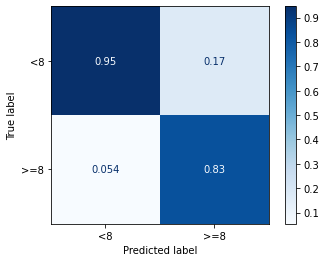

In [184]:
plot_confusion_matrix(
    clf,
    data_test,
    labels_test,
    display_labels=["<8", ">=8"],
    cmap=plt.cm.Blues,
    normalize="pred",
)

In [188]:
print(classification_report(labels_test, predicted))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2187
           1       0.83      0.26      0.40       170

    accuracy                           0.94      2357
   macro avg       0.89      0.63      0.69      2357
weighted avg       0.94      0.94      0.93      2357



In [190]:
" ".join(feature_columns)

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'hh_num nominal busy disrupted not_nom_arrival_ratio press temp atmap_visibility atmap_wind atmap_precipitation atmap_freezing atmap_danger nb_arr nb_dep nb H L L/M M H_count L_count L/M_count M_count H_count_ratio L_count_ratio L/M_count_ratio M_count_ratio turnaround_minutes'

### Feature importance

In [140]:
import matplotlib.pyplot as plt

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


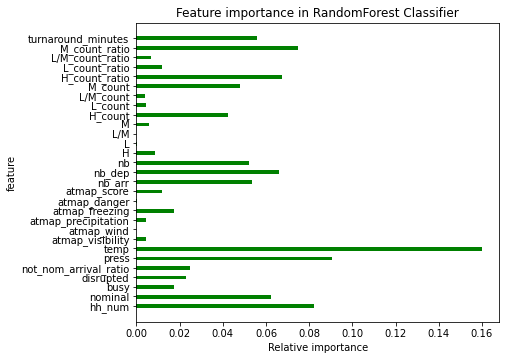

<Figure size 360x360 with 0 Axes>

In [167]:
col = feature_columns
# modelname.feature_importance_
y = clf.feature_importances_
# plot
fig, ax = plt.subplots()
width = 0.4  # the width of the bars
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="green")
ax.set_yticks(ind + width / 10)
ax.set_yticklabels(col, minor=False)
plt.title("Feature importance in RandomForest Classifier")
plt.xlabel("Relative importance")
plt.ylabel("feature")
plt.figure(figsize=(5, 5))
fig.set_size_inches(6.5, 5.5, forward=True)

In [191]:
dep_arr_3 = pd.read_pickle("../data/processed/dep_arr_df3.pkl")

In [194]:
dep_arr_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35551 entries, 0 to 35550
Data columns (total 85 columns):
 #   Column                             Non-Null Count  Dtype              
---  ------                             --------------  -----              
 0   flight_id                          35551 non-null  object             
 1   on_runway_time                     35551 non-null  datetime64[ns, UTC]
 2   taxi_holding_time                  35551 non-null  timedelta64[ns]    
 3   rwy_holding_time                   0 non-null      object             
 4   total_holding_time                 35551 non-null  timedelta64[ns]    
 5   taxi_holding_time_minutes          35551 non-null  float64            
 6   first_movement                     35551 non-null  datetime64[ns, UTC]
 7   callsign                           35551 non-null  object             
 8   registration                       28308 non-null  object             
 9   typecode                           28308 non-null 

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

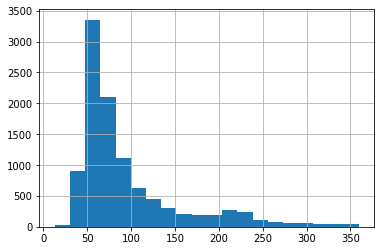

In [198]:
dep_arr_3.query("turnaround_minutes>0").turnaround_minutes.hist(bins=20)

In [200]:
dep_arr_3.query("turnaround_minutes>0").shape

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(10415, 85)

In [ ]:
dep_arr_3